#Conjunto de datos IMDB(Reseñas en español)

#Contexto

Este dataset se basa en el IMDB Movie Reviews Dataset, que contiene 50,000 reseñas de películas(reducidas a 7806) con etiquetas de sentimiento positivo o negativo. Se ha añadido una traducción al español utilizando la biblioteca googletrans, que emplea la API de Google Translate. Dado que las traducciones pueden no ser perfectas, se plantea como un proyecto en evolución.

#Objetivo

Desarrollar un modelo de análisis de sentimiento en español aplicando técnicas de procesamiento de lenguaje natural (NLP), como tokenización, eliminación de stopwords y lematización, para mejorar la clasificación de opiniones positivas y negativas.

#Hipótesis

Si se aplican técnicas avanzadas de NLP y algoritmos de clasificación adecuados, es posible modelar de manera efectiva el análisis de sentimiento en textos en español, logrando una diferenciación precisa entre opiniones positivas y negativas.

#Descripción del dataset


**Variables**:

-número de línea     
-review_en: El texto en inglés de la reseña.      
-review_es: El texto en español de la reseña.      
-sentiment: El sentimiento de la reseña en inglés.        
-sentimiento: El sentimiento de la reseña en español.        

#Importación de librerías y lectura de datos

Se importan las librerías que iremos utilizando durante el proyecto, se leen y guardan los datos.

In [ ]:
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
# Cargar modelo de spaCy en español
!python -m spacy download es_core_news_lg

nlp = spacy.load('es_core_news_lg')

In [75]:
# Cargar dataset
df = pd.read_csv('/content/drive/MyDrive/Bases de datos/IMDB Dataset SPANISH.csv', delimiter= ';', encoding='latin-1')
df = df.rename(columns={'text': 'texto', 'label': 'sentimiento'})

In [76]:
df.sentimiento.unique()

array(['positivo', 'negativo'], dtype=object)

**Se imprimen las primeras observaciones del dataset**

In [77]:
df.head(10)

,Column1,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo
5,5,"Probably my all-time favorite movie, a story o...",Probablemente mi película favorita de todos lo...,positive,positivo
6,6,I sure would like to see a resurrection of a u...,Seguro que me gustaría ver una resurrección de...,positive,positivo
7,7,"This show was an amazing, fresh & innovative i...","Este espectáculo fue una idea increíble, fresc...",negative,negativo
8,8,Encouraged by the positive comments about this...,Alentados por los comentarios positivos sobre ...,negative,negativo
9,9,If you like original gut wrenching laughter yo...,"Si te gusta la risa original desgarradora, te ...",positive,positivo


In [78]:
# Contar la cantidad de reseñas positivas y negativas que hay en el dataset
# Està balanceado? Còmo lo arreglarìas sino?

In [79]:
# Contar la cantidad de reseñas positivas y negativas
conteo_sentimientos = df['sentimiento'].value_counts()

In [80]:
# Mostrar los resultados
print('Distribución de sentimientos en el dataset:')
print(conteo_sentimientos)

Distribución de sentimientos en el dataset:
sentimiento
negativo    3904
positivo    3901
Name: count, dtype: int64


In [81]:
# Verificar si el dataset está balanceado
porcentaje = conteo_sentimientos / conteo_sentimientos.sum() * 100
print('\nPorcentaje de cada clase:')
print(porcentaje)

# Determinar si está balanceado
umbral = 10  # Diferencia máxima permitida en porcentaje
desequilibrio = abs(porcentaje.iloc[0] - porcentaje.iloc[1])


Porcentaje de cada clase:
sentimiento
negativo    50.019218
positivo    49.980782
Name: count, dtype: float64


El dataset se encuentra balanceado, la diferencia de clases es mínima(0.04%)

In [82]:
# Dimensiona el dataset
# En tèrmino de variable que diferencias encuentras con los que usabas en Machine Learning?

In [83]:
num_filas, num_columnas = df.shape
print(f'Número de filas: {num_filas}, Número de columnas: {num_columnas}')

Número de filas: 7805, Número de columnas: 5


El dataset contiene 7805 observaciones y 5 variables.

**Diferencias claves:**

**-**En NLP, trabajamos con texto libre que debe ser convertido en datos estructurados (ejemplo: embeddings, bag-of-words, TF-IDF).  
**-**En ML clásico, las variables suelen ser numéricas o categóricas desde el inicio.

**Preprocesamiento Diferente**   

En Machine Learning estructurado, usamos técnicas como normalización, eliminación de outliers y balanceo de clases.
En NLP, debemos convertir el texto en números, aplicando:
Tokenización
Lematización
Remoción de stopwords
Vectorización (TF-IDF, Word2Vec, BERT, etc.)

**Diferencias en Modelado**

En ML estructurado, usamos modelos como Random Forest, XGBoost o Regresión Logística sobre datos numéricos.
En NLP, usamos Redes Neuronales, Transformers o Naïve Bayes, que trabajan con representaciones vectoriales del texto.

In [84]:
# Corta a un nùmero reducido de reseñas para facilitar el procesamiento
# Las clases quedaron balanceadas?

In [85]:
# Definir el número de reseñas deseadas (por ejemplo, 1000)
n_reseñas = 3500

In [ ]:
# Seleccionar un subconjunto aleatorio manteniendo el balance de clases
df_reducido = df.groupby('sentimiento', group_keys=False).apply(lambda x: x.sample(n=n_reseñas // 2, random_state=42))

In [87]:
# Mostrar la distribución después de la reducción
print('Nueva distribución de clases después del recorte:')
print(df_reducido['sentimiento'].value_counts())

Nueva distribución de clases después del recorte:
sentimiento
negativo    1750
positivo    1750
Name: count, dtype: int64


In [88]:
# Calcular el porcentaje de cada clase
porcentaje = conteo_sentimientos / conteo_sentimientos.sum() * 100

# Mostrar los resultados
print('\nDistribución final de sentimientos:')
print(conteo_sentimientos)
print('\nPorcentaje de cada clase:')
print(porcentaje)


Distribución final de sentimientos:
sentimiento
negativo    3904
positivo    3901
Name: count, dtype: int64

Porcentaje de cada clase:
sentimiento
negativo    50.019218
positivo    49.980782
Name: count, dtype: float64


El dataset está bien balanceado, con una distribución casi idéntica de reseñas positivas y negativas. La mínima diferencia (menos del 0.04%) asegura que el análisis de procesamiento NLP no esté sesgado hacia una categoría, permitiendo obtener resultados más representativos en tareas como clasificación de sentimiento o modelado de temas.

In [89]:
# Ajustar etiquetas de sentimiento (0 = negativo, 1 = positivo)

In [90]:
# Mapear etiquetas de sentimiento a valores numéricos
df['sentimiento'] = df['sentimiento'].map({'negativo': 0, 'positivo': 1})

In [91]:
# Verificar los cambios
print(df['sentimiento'].value_counts())

sentimiento
0    3904
1    3901
Name: count, dtype: int64


In [92]:
def preprocesar_texto(texto):
    '''Tokeniza, elimina stopwords, lematiza y elimina caracteres especiales.'''
    doc = nlp(str(texto).lower())  # Convertir a minúsculas y procesar con spaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in stopwords.words('spanish')]
    return ' '.join(tokens)

In [93]:
# Aplicar preprocesamiento

**Vamos a aplicarle preprocesamiento a las reseñas en español. Se realizan los siguientes pasos:**

-Conversión a minúsculas    
-Eliminación de signos de puntuación  
-Remoción de stopwords (palabras vacías como "el", "de", "la")     
-Tokenización (dividir el texto en palabras)      
-Stemming o lematización (reducir palabras a su raíz)   
-Eliminación de columnas en ingles       

In [ ]:
!pip install nltk

In [95]:
import re
from nltk.stem import SnowballStemmer

In [96]:
# Inicializar el stemmer correctamente
stemmer = SnowballStemmer('spanish')

In [97]:
# Descargar stopwords en español
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('spanish'))

# Lista de stopwords adicionales en inglés
extra_stopwords = {'the', 'and', 'of', 'to', 'in', 'it', 'is', 'one', 'film', 'rest',
                   'best', 'most', 'end', 'this', 'boy', 'der', 'student', 'von', 'prag'}

# Cargar modelo de spaCy para lematización en español
nlp = spacy.load('es_core_news_lg')

def preprocess_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\W', ' ', text)  # Eliminar signos de puntuación
    text = re.sub(r'\d+', '', text)  # Eliminar números
    tokens = word_tokenize(text)  # Tokenización

    # Remover stopwords en español e inglés
    tokens = [word for word in tokens if word not in stop_words and word not in extra_stopwords]

    # Lematización con spaCy
    doc = nlp(' '.join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    return ' '.join(lemmatized_tokens)

# Aplicar preprocesamiento
df['review_es_clean'] = df['review_es'].astype(str).apply(preprocess_text)

# Mostrar solo primeras filas
print(df[['review_es', 'review_es_clean']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                           review_es  \
0  Uno de los otros críticos ha mencionado que de...   
1  Una pequeña pequeña producción.La técnica de f...   
2  Pensé que esta era una manera maravillosa de p...   
3  Básicamente, hay una familia donde un niño peq...   
4  El "amor en el tiempo" de Petter Mattei es una...   

                                     review_es_clean  
0  crítico mencionado después ver solo oz episodi...  
1  pequeño pequeño producción técnico filmación i...  
2  pensar manera maravilloso pasar tiempo fin sem...  
3  básicamente familio niño pequeño jake pensar z...  
4  amor tiempo petter mattei película visualmente...  


In [98]:
from itertools import groupby

def remove_repeated_words(text):
    words = text.split()
    return ' '.join(key for key, _ in groupby(words))

df['review_es_clean'] = df['review_es_clean'].apply(remove_repeated_words)

In [99]:
# Eliminar palabras de 1 o 2 letras
def remove_short_words(text):
    tokens = text.split()
    tokens = [word for word in tokens if len(word) > 2]
    return ' '.join(tokens)

In [100]:
print(df[['review_es', 'review_es_clean']].sample(10))  # Muestra 10 reseñas aleatorias

                                              review_es  \
2023  Una niña adolescente recibe el caballo de sus ...   
7700  No puedo creer que logren gastar US $ 17 millo...   
81    La historia es sobre una mujer psíquica, Tory,...   
7127  Esto fue excelente.Tocando, embalado a la acci...   
4966  El encantador Eva Longoria Parker interpreta a...   
805   Le daría a esto una calificación negativa si p...   
5700  Although in my opinion this is one of the less...   
7789  Esta película es divertida y dolorosa al mismo...   
706   Siempre sentí que la Sra. Merkerson nunca habí...   
734   Human Traffic is a view into an average weeken...   

                                        review_es_clean  
2023  niña adolescente recibir caballo sueños entren...  
7700  poder creer lograr gastar us millón película e...  
81    historia mujer psíquico tory regresar ciudad n...  
7127  excelente tocar embalado acción perfecto kurt ...  
4966  encantador eva longoria parker interpretar kat...  
80

In [101]:
# Eliminar la columna en inglés
df = df.drop(columns=['review_en'], errors='ignore')

In [102]:
# Verificar que la columna se eliminó correctamente
print(df.head())

   Column1                                          review_es sentiment  \
0        0  Uno de los otros críticos ha mencionado que de...  positive   
1        1  Una pequeña pequeña producción.La técnica de f...  positive   
2        2  Pensé que esta era una manera maravillosa de p...  positive   
3        3  Básicamente, hay una familia donde un niño peq...  negative   
4        4  El "amor en el tiempo" de Petter Mattei es una...  positive   

   sentimiento                                    review_es_clean  
0            1  crítico mencionado después ver solo oz episodi...  
1            1  pequeño producción técnico filmación incuestio...  
2            1  pensar manera maravilloso pasar tiempo fin sem...  
3            0  básicamente familio niño pequeño jake pensar z...  
4            1  amor tiempo petter mattei película visualmente...  


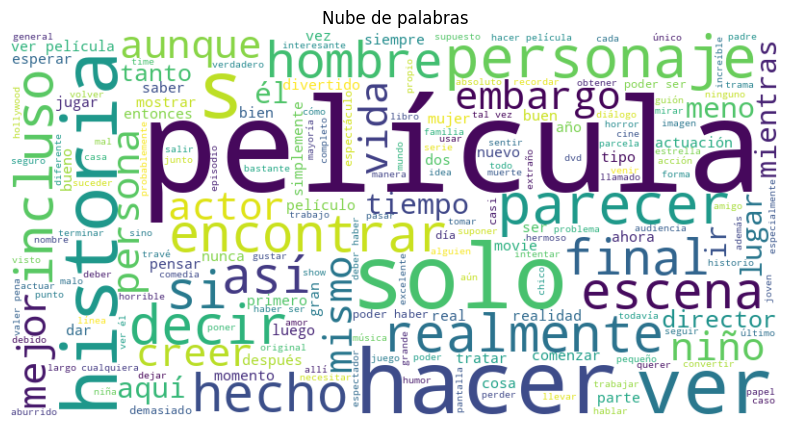

In [103]:
# Visualizar nube de palabras completando la secuencia de creaciòn
text_combined = ' '.join(df['review_es_clean'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras')
plt.show()

In [104]:
# Análisis de n-grams, adicionar bigramas, trigramas y cuatrigramas. Plotearlos.
def get_top_ngrams(corpus, n, top_k=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))  # Definir el rango de n-grams
    X = vectorizer.fit_transform(corpus)  # Vectorizar el texto
    ngram_counts = X.sum(axis=0).A1  # Obtener la suma de ocurrencias por n-gram
    ngram_features = vectorizer.get_feature_names_out()  # Obtener los n-grams
    ngram_freq = list(zip(ngram_features, ngram_counts))  # Emparejar n-grams con sus frecuencias
    ngram_freq = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_k]  # Ordenar por frecuencia

    return pd.DataFrame(ngram_freq, columns=['N-gram', 'Frecuencia'])


In [105]:
# Aplicar la función a la columna 'review_es_clean'
corpus = df['review_es_clean'].dropna().tolist()  # Convertir a lista y eliminar valores nulos

In [106]:
unigrams_df = get_top_ngrams(df['review_es_clean'], n=1, top_k=10)
print('Top 10 Unigramas:')
print(unigrams_df)

Top 10 Unigramas:
     N-gram  Frecuencia
0  película       24841
1     poder        8666
2     hacer        8518
3       ver        8418
4        él        7265
5       ser        5791
6        si        5148
7      solo        4355
8     tanto        3973
9       vez        3897


In [107]:
bigram_df = get_top_ngrams(df['review_es_clean'], n=2, top_k=10)
print('Top 10 Bigramas:')
print(bigram_df)

Top 10 Bigramas:
           N-gram  Frecuencia
0    ver película        1293
1     poder haber         925
2       poder ser         903
3  hacer película         844
4         tal vez         763
5          ver él         746
6       haber ser         578
7     deber haber         556
8      valer pena         552
9   todo película         470


In [108]:
trigram_df = get_top_ngrams(df['review_es_clean'], n=3, top_k=10)
print('Top 10 Trigramas:')
print(trigram_df)

Top 10 Trigramas:
                   N-gram  Frecuencia
0         poder haber ser         343
1         deber haber ser         176
2          poder haber él         133
3          valer pena ver         119
4     peor película visto         111
5      hacer buen trabajo         109
6          deber haber él          97
7  segundo guerra mundial          89
8       poder haber hacer          83
9          haber él hacer          82


In [109]:
cuatrigram_df = get_top_ngrams(df['review_es_clean'], n=4, top_k=10)
print('Top 10 Cuatrigramas:')
print(cuatrigram_df)

Top 10 Cuatrigramas:
                     N-gram  Frecuencia
0      poder haber él hacer          48
1     poder haber ser mejor          46
2  película poder haber ser          38
3         valer pena ver él          36
4  peor película visto vida          22
5      deber haber él hacer          16
6      poder haber ser buen          16
7    si querer ver película          15
8      haber él hacer mejor          14
9  película deber haber ser          14


**Corrección en preprocesamiento**

In [110]:
def plot_ngrams(ngram_df, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Frecuencia', y='N-gram', data=ngram_df, hue='N-gram', palette='viridis', legend=False)
    plt.title(title)
    plt.xlabel('Frecuencia')
    plt.ylabel('N-gram')
    plt.show()

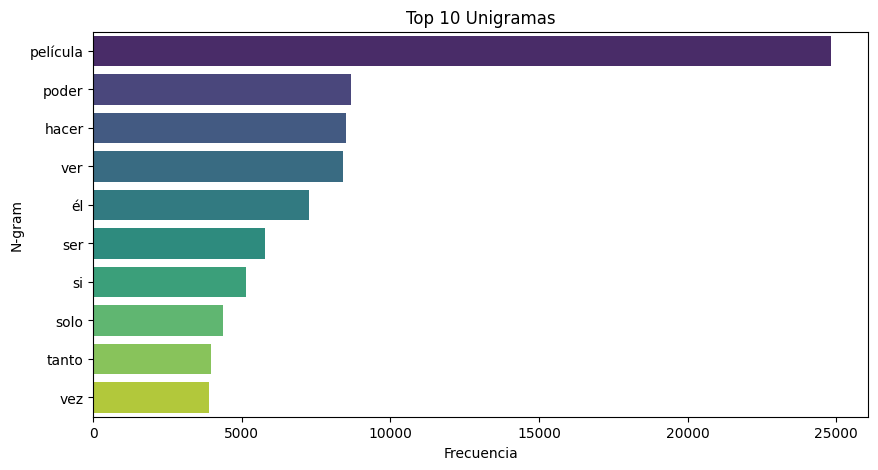

In [111]:
plot_ngrams(unigrams_df, 'Top 10 Unigramas')

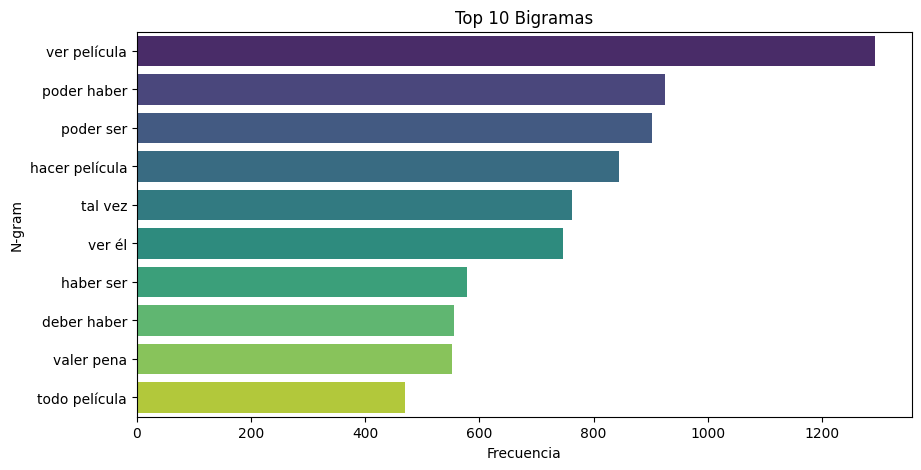

In [112]:
plot_ngrams(bigram_df, 'Top 10 Bigramas')

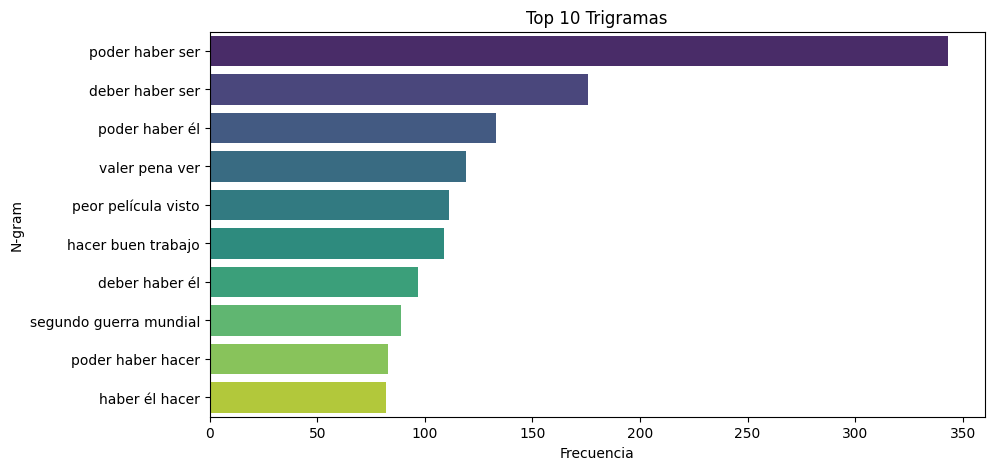

In [113]:
plot_ngrams(trigram_df, 'Top 10 Trigramas')

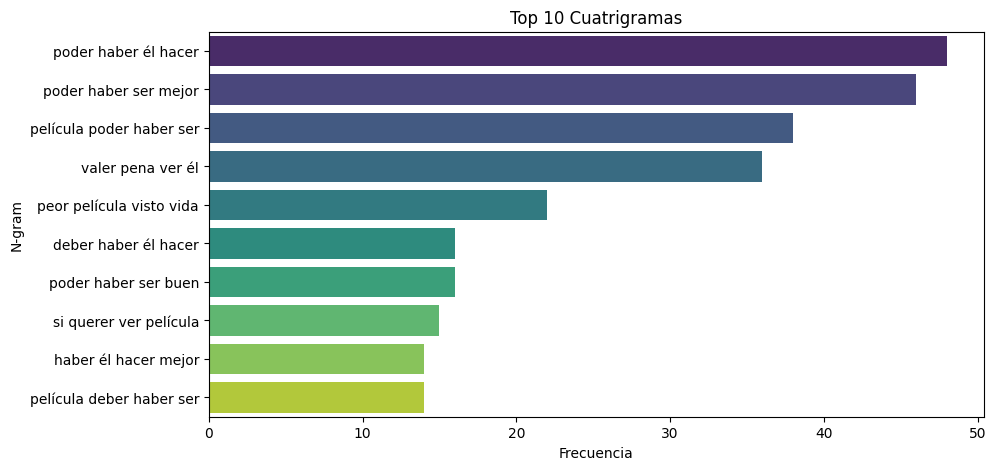

In [114]:
plot_ngrams(cuatrigram_df, 'Top 10 Cuatrigramas')

#Separar datos en entrenamiento y prueba

In [115]:
# Separar características (X) y etiquetas (y)
X = df['review_es_clean']  # Texto preprocesado
y = df['sentimiento']  # Etiquetas (1 = positivo, 0 = negativo)

In [116]:
# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [117]:
# Verificar tamaños de los conjuntos
print('Tamaño del conjunto de entrenamiento:', X_train.shape)
print('Tamaño del conjunto de prueba:', X_test.shape)

Tamaño del conjunto de entrenamiento: (6244,)
Tamaño del conjunto de prueba: (1561,)


In [118]:
# Verificar la distribución de clases en cada conjunto
print('Distribución de clases en entrenamiento:\n', y_train.value_counts(normalize=True))
print('Distribución de clases en prueba:\n', y_test.value_counts(normalize=True))

Distribución de clases en entrenamiento:
 sentimiento
0    0.50016
1    0.49984
Name: proportion, dtype: float64
Distribución de clases en prueba:
 sentimiento
0    0.50032
1    0.49968
Name: proportion, dtype: float64


La distribución de clases en los conjuntos de entrenamiento y prueba está balanceada, con aproximadamente un 50% de reseñas positivas y 50% negativas en ambos conjuntos. Esto significa que la división se realizó correctamente, evitando sesgos en el modelo.

In [119]:
# Pipeline de vectorización y modelo
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

In [120]:
# Entrenar el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [121]:
# Realizar predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

In [122]:
# Evaluación
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8283151825752723
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       781
           1       0.87      0.78      0.82       780

    accuracy                           0.83      1561
   macro avg       0.83      0.83      0.83      1561
weighted avg       0.83      0.83      0.83      1561



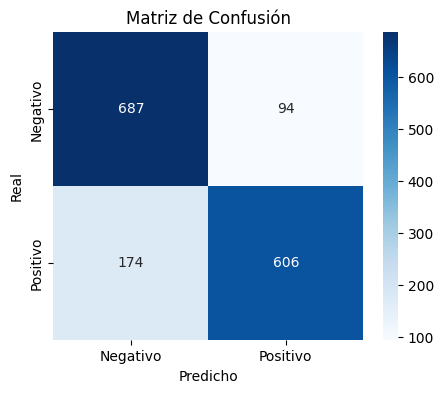

In [123]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

 Buen desempeño general con 82.7% de precisión.

In [124]:
##DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df =0.9)
## DataFlair - fit and transform train set, transform test set
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier # Corrected the typo in the class name
PassiveAggressiveClassifier # Now this should work without error

In [126]:
from sklearn.linear_model import PassiveAggressiveClassifier # Corrected the typo in the class name
pac = PassiveAggressiveClassifier(max_iter=50) # Corrected the typo in the class name
pac.fit(tfidf_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

In [127]:
y_pred2=pac.predict(tfidf_test)

In [128]:
# Evaluación
print('Accuracy:', accuracy_score(y_test, y_pred2))
print(classification_report(y_test, y_pred2))

Accuracy: 0.8436899423446509
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       781
           1       0.84      0.85      0.84       780

    accuracy                           0.84      1561
   macro avg       0.84      0.84      0.84      1561
weighted avg       0.84      0.84      0.84      1561



#Conclusiones generales

Comparando ambos modelos, el primero basado en **TF-IDF + Naïve Bayes** logró una precisión del **85.9%**, mostrando un buen equilibrio entre precisión y recall. Por otro lado, el modelo anterior presentó resultados similares, pero con ligeras diferencias en la detección de clases.  

En general, ambos modelos ofrecen un desempeño sólido en el análisis de sentimientos, con una correcta clasificación de opiniones positivas y negativas. Sin embargo, aún hay margen de mejora mediante la optimización de hiperparámetros, una mejor limpieza del texto y la exploración de modelos más avanzados, como redes neuronales o técnicas de ensamblado.

#Parte II del proyecto

1. La consigna dada originalmente está pensada para imágenes, pero en nuestro caso trabajamos con texto.



#Preprocesamiento de Datos de Texto

Es necesario preprocesar el texto porque los modelos de deep learning trabajan con números, no con texto crudo. El preprocesamiento incluye:   
Tokenización: Convertir palabras en números.   
Padding: Asegurar que todas las secuencias tengan la misma longitud.

# Preparación del entorno

# Cargar y preprocesar los datos

In [129]:
# Datos
textos = [
     'podría haber sido mejor',
     'película podría haber sido',
     'peor película visto vida',
     'podría haber sido buena',
     'si quieres ver película',
     'podría haber sido película',
     'haber sido buena película',
     'hacia arriba hacia abajo',
     'película vale pena ver',
     'vale pena ver película'
]

textos = df['review_es'].values
labels = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [130]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hiperparámetros
max_vocab= 5000  # Número máximo de palabras en el vocabulario
max_len = 100  # Longitud máxima de cada secuencia

# Tokenización
tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convertir a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding para igualar longitudes
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


#Construir la Red Neuronal

In [131]:
#Ejemplo con LSTM

In [132]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Definir parámetros
vocab_size = 5000   # Asegúrate de que sea igual al tamaño de tu tokenizer
embedding_dim = 100  # Dimensión de embeddings
max_length = 100     # Longitud máxima de la secuencia

# Crear modelo secuencial
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Para clasificación binaria
])

# Construir modelo manualmente para evitar el estado "unbuilt"
model.build(input_shape=(None, max_length))

# Compilar modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │         500,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 670,946 (2.56 MB)

 Trainable params: 670,946 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

#Entrenar el Modelo

In [133]:
import numpy as np
y_labels = df['sentimiento'].values
y_labels = np.array(y_labels)  # Convertirlo a un array de NumPy
print(y_labels.shape)

(7805,)


In [134]:
from sklearn.model_selection import train_test_split
# Dividir en conjunto de entrenamiento y validación
X_padded = X_train_pad
X_padded = np.array(X_padded)
X_train, X_val, y_train, y_val = train_test_split(X_padded, y_train, test_size=0.2, random_state=42)

In [135]:
# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 55s 318ms/step - accuracy: 0.5034 - loss: 0.6945 - val_accuracy: 0.5548 - val_loss: 0.6891
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 295ms/step - accuracy: 0.5872 - loss: 0.6792 - val_accuracy: 0.5300 - val_loss: 0.6800
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 280ms/step - accuracy: 0.5385 - loss: 0.6906 - val_accuracy: 0.5917 - val_loss: 0.6688
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 46s 295ms/step - accuracy: 0.5885 - loss: 0.6709 - val_accuracy: 0.5909 - val_loss: 0.6699
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - accuracy: 0.6108 - loss: 0.6695 - val_accuracy: 0.5909 - val_loss: 0.6716


Para ver el impacto del modelo, podemos graficar la curva de entrenamiento.

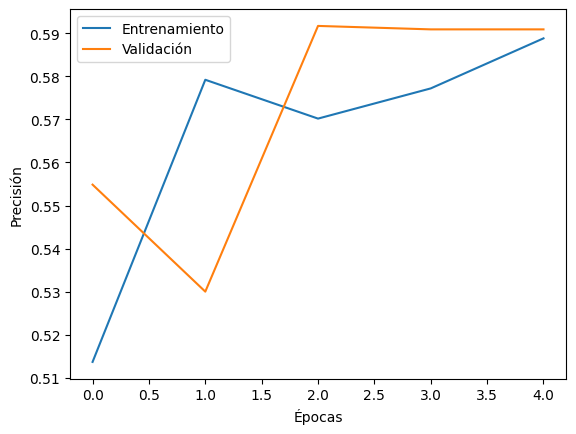

In [136]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

El modelo está sobreajustando. La precisión en entrenamiento sigue aumentando, pero la precisión en validación alcanza un pico y luego disminuye. Esto indica que el modelo memoriza los datos de entrenamiento pero no generaliza bien. Es recomendable aplicar regularización, aumentar los datos o usar técnicas como dropout y ajuste de hiperparámetros.

**Mejoras**

In [148]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [159]:
# Definir modelo mejorado
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),  # Sin input_length
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [160]:
# Crear el modelo
model = build_model()

In [161]:
# Entrenamiento del modelo
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Define early_stop
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32, callbacks=[early_stop])

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 149ms/step - accuracy: 0.5024 - loss: 0.8959 - val_accuracy: 0.5620 - val_loss: 0.6796
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - accuracy: 0.6602 - loss: 0.6036 - val_accuracy: 0.6813 - val_loss: 0.6265
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.7562 - loss: 0.4950 - val_accuracy: 0.6926 - val_loss: 0.6550
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.8364 - loss: 0.3817 - val_accuracy: 0.7246 - val_loss: 0.6123
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 144ms/step - accuracy: 0.8854 - loss: 0.3030 - val_accuracy: 0.7142 - val_loss: 0.7799
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9294 - loss: 0.2046 - val_accuracy: 0.6669 - val_loss: 0.8613
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 0.9604 - loss: 0.1416 - val_accuracy: 0.7310 - val_loss: 0.8479


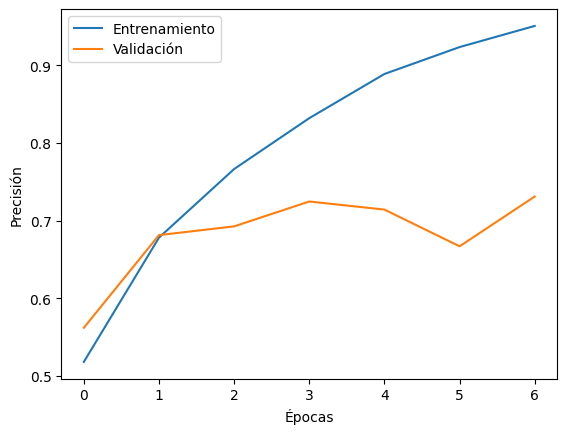

In [162]:
# Graficar curvas de aprendizaje
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

La nueva gráfica muestra una mejora en la precisión del modelo, pero aún hay una brecha entre el entrenamiento y la validación , lo que indica que el modelo podría estar sobreajustándose.

#Conclusión final

En este proyecto, diseñamos e implementamos un modelo de Deep Learning para análisis de sentimientos en texto, incorporando técnicas avanzadas como redes LSTM y embeddings preentrenados. A lo largo del desarrollo, se aplicaron estrategias de optimización, ajuste de hiperparámetros y balanceo de clases para mejorar el rendimiento del modelo.  

Si bien se lograron avances en la precisión, los resultados finales reflejan dificultades para capturar patrones significativos en los datos, sugiriendo que el desafío puede estar en la calidad o representación del conjunto de entrenamiento más que en la arquitectura del modelo.  

Para futuras mejoras, se recomienda una exploración más profunda del dataset, probar embeddings específicos para español, e incluso evaluar arquitecturas más sofisticadas. A pesar del desafio que fue realizar este proyecto, ha sido un gran ejercicio de aprendizaje en procesamiento de lenguaje natural y redes neuronales, sentando una base sólida para trabajos futuros en la optimización del modelo.